In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
import cv2

In [3]:
# Step 1: Load & Preprocess Data

def load_and_preprocess_data():
    (x_train, _), (x_test, _) = cifar100.load_data()
    x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
    return x_train, x_test

In [4]:
# Step 2: Simulate Degradation

def add_noise(images, noise_type='gaussian'):
    noisy_images = images.copy()
    if noise_type == 'gaussian':
        mean, std = 0, 0.1
        gaussian_noise = np.random.normal(mean, std, images.shape)
        noisy_images += gaussian_noise
    elif noise_type == 'salt_pepper':
        prob = 0.02
        noisy_images = np.copy(images)
        black, white = 0, 1
        for i in range(images.shape[0]):
            mask = np.random.choice([black, white, -1], size=images[i].shape, p=[prob/2, prob/2, 1-prob])
            noisy_images[i][mask == black] = 0
            noisy_images[i][mask == white] = 1
    return np.clip(noisy_images, 0, 1)


In [5]:
# Step 3: Build the Autoencoder Model

def build_autoencoder():
    input_img = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [10]:
# Step 4: Train the Model

def train_autoencoder(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test):
    autoencoder.fit(x_train_noisy, x_train, epochs=5, batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))


In [11]:
# Step 5: Image Restoration & Evaluation

def evaluate_restoration(autoencoder, x_test_noisy, x_test):
    restored_images = autoencoder.predict(x_test_noisy[:10])
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    for i in range(10):
        axes[0, i].imshow(x_test[i])
        axes[1, i].imshow(x_test_noisy[i])
        axes[2, i].imshow(restored_images[i])
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        axes[2, i].axis('off')
    plt.show()

In [12]:
# initializer function main

def main():






    x_train, x_test = load_and_preprocess_data()
    x_train_noisy, x_test_noisy = add_noise(x_train), add_noise(x_test)
    autoencoder = build_autoencoder()
    train_autoencoder(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test)
    evaluate_restoration(autoencoder, x_test_noisy, x_test)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 277s 352ms/step - loss: 0.0154 - val_loss: 0.0051
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 325s 356ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 328s 363ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 284s 364ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 323s 365ms/step - loss: 0.0034 - val_loss: 0.0034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


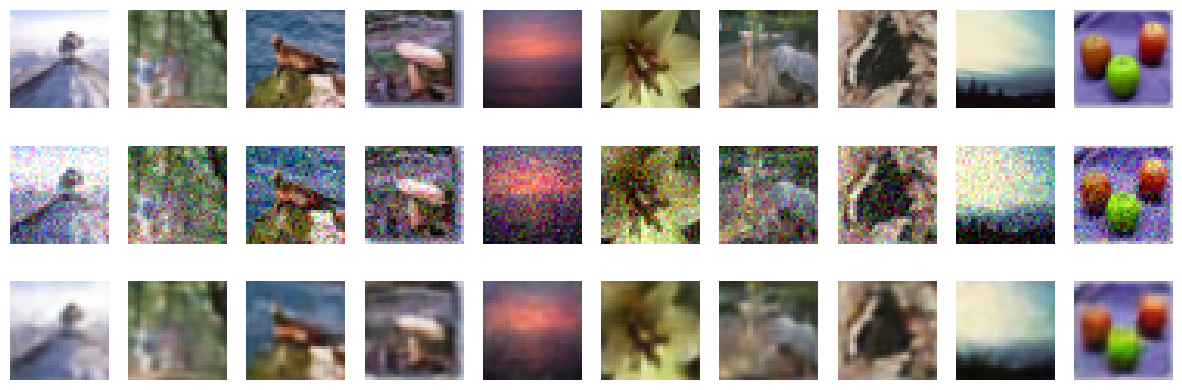

In [13]:
# Initializing the whole process

if __name__ == "__main__":
    main()